# <b><u>README</u></b>

**Important Pre-requisites**

>*   Upgrade pip <code> pip install --upgrade pip</code>
>*   Keras - <code> pip install keras </code>
>*   Tensorflow - <code> pip install tensorflow </code>
>*   Statsmodels - <code> pip install statsmodels </code>
>*   Google Colaboratory


**Roadmap**

>* Click File > Open Notebook > Upload Tab > select csv file
>* Runtime >> Change Runtime type >> <code>GPU</code>
>* Click the folder icon >> Upload <code>allstateshistory.csv</code>
>* Right click on the uploaded csv file> Click Copy Path > Paste the path of uploaded file into the <code>path</code> variable under Import Data section
>* Runtime >> Run all






---



# **<u>QUESTION WE ARE TRYING TO ANSWER**

## <b><mark>Does Presidency really contribute to the proliferation of COVID cases in the United States? If so, what would we be the consequency?</mark></b>



---



## **Import Libraries**

In [ ]:
import numpy
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import seaborn as sns
import pandas as pd
import math
import decimal

# Libraries for the LSTM Neural Network
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score,accuracy_score
from keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.tsa.seasonal import seasonal_decompose

## **Import Data**

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/allstateshistory.csv'
data = pd.read_csv(path, parse_dates=True, low_memory=False)
data.head()

,date,state,death,deathConfirmed,deathIncrease,deathProbable,hospitalized,hospitalizedCumulative,hospitalizedCurrently,hospitalizedIncrease,inIcuCumulative,inIcuCurrently,negative,negativeIncrease,negativeTestsAntibody,negativeTestsPeopleAntibody,negativeTestsViral,onVentilatorCumulative,onVentilatorCurrently,positive,positiveCasesViral,positiveIncrease,positiveScore,positiveTestsAntibody,positiveTestsAntigen,positiveTestsPeopleAntibody,positiveTestsPeopleAntigen,positiveTestsViral,recovered,totalTestEncountersViral,totalTestEncountersViralIncrease,totalTestResults,totalTestResultsIncrease,totalTestsAntibody,totalTestsAntigen,totalTestsPeopleAntibody,totalTestsPeopleAntigen,totalTestsPeopleViral,totalTestsPeopleViralIncrease,totalTestsViral,totalTestsViralIncrease,presidentRule,politicalParty
0,7/3/2021,AK,305.0,NaN,0,NaN,1293.0,1293.0,33.0,0,NaN,NaN,NaN,0,NaN,NaN,1660758.0,NaN,2.0,56886.0,NaN,0,0,NaN,NaN,NaN,NaN,68693.0,NaN,NaN,0,1731628.0,0,NaN,NaN,NaN,NaN,NaN,0,1731628.0,0,Biden,Republican
1,7/3/2021,AL,10148.0,7963.0,-1,2185.0,45976.0,45976.0,494.0,0,2676.0,NaN,1931711.0,2087,NaN,NaN,NaN,1515.0,NaN,499819.0,392077.0,408,0,NaN,NaN,NaN,NaN,NaN,295690.0,NaN,0,2323788.0,2347,NaN,NaN,119757.0,NaN,2323788.0,2347,NaN,0,Biden,Republican
2,7/3/2021,AR,5319.0,4308.0,22,1011.0,14926.0,14926.0,335.0,11,NaN,141.0,2480716.0,3267,NaN,NaN,2480716.0,1533.0,65.0,324818.0,255726.0,165,0,NaN,NaN,NaN,81803.0,NaN,315517.0,NaN,0,2736442.0,3380,NaN,NaN,NaN,481311.0,NaN,0,2736442.0,3380,Biden,Republican
3,7/3/2021,AS,0.0,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,2140.0,0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2140.0,0,NaN,NaN,NaN,NaN,NaN,0,2140.0,0,Biden,NaN
4,7/3/2021,AZ,16328.0,14403.0,5,1925.0,57907.0,57907.0,963.0,44,NaN,273.0,3073010.0,13678,NaN,NaN,NaN,NaN,143.0,826454.0,769935.0,1335,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,7908105.0,45110,580569.0,NaN,444089.0,NaN,3842945.0,14856,7908105.0,45110,Biden,Republican


In [ ]:
# Repalce NaN values with float value 0.0
data.replace(numpy.nan, 0.0,inplace=True)

# Convert datetime from string to datetime datatype
data['date'] = pd.to_datetime(data['date'], format = '%d/%m/%Y')

#Preping data in ascending order by sorting both the dataframe values and index
data = data[::-1]
data.reset_index(drop = True)
data.index = data.index[::-1]
data.shape

(20780, 43)

In [ ]:
data.tail(5)

,date,state,death,deathConfirmed,deathIncrease,deathProbable,hospitalized,hospitalizedCumulative,hospitalizedCurrently,hospitalizedIncrease,inIcuCumulative,inIcuCurrently,negative,negativeIncrease,negativeTestsAntibody,negativeTestsPeopleAntibody,negativeTestsViral,onVentilatorCumulative,onVentilatorCurrently,positive,positiveCasesViral,positiveIncrease,positiveScore,positiveTestsAntibody,positiveTestsAntigen,positiveTestsPeopleAntibody,positiveTestsPeopleAntigen,positiveTestsViral,recovered,totalTestEncountersViral,totalTestEncountersViralIncrease,totalTestResults,totalTestResultsIncrease,totalTestsAntibody,totalTestsAntigen,totalTestsPeopleAntibody,totalTestsPeopleAntigen,totalTestsPeopleViral,totalTestsPeopleViralIncrease,totalTestsViral,totalTestsViralIncrease,presidentRule,politicalParty
20775,2021-03-07,AZ,16328.0,14403.0,5,1925.0,57907.0,57907.0,963.0,44,0.0,273.0,3073010.0,13678,0.0,0.0,0.0,0.0,143.0,826454.0,769935.0,1335,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,7908105.0,45110,580569.0,0.0,444089.0,0.0,3842945.0,14856,7908105.0,45110,Biden,Republican
20776,2021-03-07,AS,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,2140.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2140.0,0,0.0,0.0,0.0,0.0,0.0,0,2140.0,0,Biden,0.0
20777,2021-03-07,AR,5319.0,4308.0,22,1011.0,14926.0,14926.0,335.0,11,0.0,141.0,2480716.0,3267,0.0,0.0,2480716.0,1533.0,65.0,324818.0,255726.0,165,0,0.0,0.0,0.0,81803.0,0.0,315517.0,0.0,0,2736442.0,3380,0.0,0.0,0.0,481311.0,0.0,0,2736442.0,3380,Biden,Republican
20778,2021-03-07,AL,10148.0,7963.0,-1,2185.0,45976.0,45976.0,494.0,0,2676.0,0.0,1931711.0,2087,0.0,0.0,0.0,1515.0,0.0,499819.0,392077.0,408,0,0.0,0.0,0.0,0.0,0.0,295690.0,0.0,0,2323788.0,2347,0.0,0.0,119757.0,0.0,2323788.0,2347,0.0,0,Biden,Republican
20779,2021-03-07,AK,305.0,0.0,0,0.0,1293.0,1293.0,33.0,0,0.0,0.0,0.0,0,0.0,0.0,1660758.0,0.0,2.0,56886.0,0.0,0,0,0.0,0.0,0.0,0.0,68693.0,0.0,0.0,0,1731628.0,0,0.0,0.0,0.0,0.0,0.0,0,1731628.0,0,Biden,Republican


# **EXPLORATORY DATA ANALYSIS**

In [ ]:
state = data['state'].unique()
state.sort()
state

array(['AK', 'AL', 'AR', 'AS', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL',
       'GA', 'GU', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA',
       'MD', 'ME', 'MI', 'MN', 'MO', 'MP', 'MS', 'MT', 'NC', 'ND', 'NE',
       'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI',
       'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VI', 'VT', 'WA', 'WI', 'WV',
       'WY'], dtype=object)

Plotly use two-lettered codes to map different states in United States. Thus it is of critical importance for us to create a dictionary to maps to specific states as provided in the dataset

In [ ]:
code = {'Alaska': 'AK',
        'Alabama': 'AL',
        'Arkansas': 'AR',
        'Arizona': 'AZ',
        'California': 'CA',
        'Colorado': 'CO',
        'Connecticut': 'CT',
        'District of Columbia': 'DC',
        'Delaware': 'DE',
        'Florida': 'FL',
        'Georgia': 'GA',
        'Hawaii': 'HI',
        'Iowa': 'IA',
        'Idaho': 'ID',
        'Illinois': 'IL',
        'Indiana': 'IN',
        'Kansas': 'KS',
        'Kentucky': 'KY',
        'Louisiana': 'LA',
        'Massachusetts': 'MA',
        'Maine': 'ME',
        'Maryland': 'MD',
        'Michigan': 'MI',
        'Minnesota': 'MN',
        'Missouri': 'MO',
        'Mississippi': 'MS',
        'Montana': 'MT',
        'Nebraska': 'NE',
        'North Carolina': 'NC',
        'North Dakota': 'ND',
        'New Hampshire': 'NH',
        'New Jersey': 'NJ',
        'New Mexico': 'NM',
        'Nevada': 'NV',
        'New York': 'NY',     
        'Ohio': 'OH',
        'Oklahoma': 'OK',
        'Oregon': 'OR',
        'Pennsylvania': 'PA',
        'Rhode Island': 'RI',
        'South Carolina': 'SC',
        'South Dakota': 'SD',
        'Tennessee': 'TN',
        'Texas': 'TX',
        'Utah': 'UT',
        'Virginia': 'VA',
        'Vermont': 'VT',
        'Washington': 'WA',
        'Wisconsin': 'WI',
        'West Virginia': 'WV',
        'Wyoming': 'WY'}

In [ ]:
code = dict((v, k) for k, v in code.items())
data['code'] = data['state'].map(code)
data['code'].head()

0    Washington
1    Washington
2    Washington
3    Washington
4    Washington
Name: code, dtype: object

In [ ]:
state_df = data.groupby(by = 'state', as_index = True).sum()
state_df[['deathIncrease','positiveIncrease','hospitalizedIncrease']].describe()

,deathIncrease,positiveIncrease,hospitalizedIncrease
count,56.000000,5.600000e+01,56.000000
mean,9199.125000,5.135070e+05,13863.517857
std,11483.305954,6.480319e+05,19439.350736
min,0.000000,0.000000e+00,0.000000
25%,1778.750000,1.014488e+05,0.000000
50%,5180.000000,3.346750e+05,5433.500000
75%,11512.250000,6.302550e+05,19966.000000
max,54124.000000,3.501341e+06,82237.000000


In [ ]:
state_df.head()

,death,deathConfirmed,deathIncrease,deathProbable,hospitalized,hospitalizedCumulative,hospitalizedCurrently,hospitalizedIncrease,inIcuCumulative,inIcuCurrently,negative,negativeIncrease,negativeTestsAntibody,negativeTestsPeopleAntibody,negativeTestsViral,onVentilatorCumulative,onVentilatorCurrently,positive,positiveCasesViral,positiveIncrease,positiveScore,positiveTestsAntibody,positiveTestsAntigen,positiveTestsPeopleAntibody,positiveTestsPeopleAntigen,positiveTestsViral,recovered,totalTestEncountersViral,totalTestEncountersViralIncrease,totalTestResults,totalTestResultsIncrease,totalTestsAntibody,totalTestsAntigen,totalTestsPeopleAntibody,totalTestsPeopleAntigen,totalTestsPeopleViral,totalTestsPeopleViralIncrease,totalTestsViral,totalTestsViralIncrease
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AK,31486.0,14454.0,305,0.0,157626.0,157626.0,17804.0,1293,0.0,0.0,0.0,0,0.0,0.0,190723351.0,0.0,2101.0,6158147.0,0.0,56886,0,0.0,0.0,0.0,0.0,7137629.0,482296.0,0.0,0,208217690.0,1731620,0.0,0.0,0.0,0.0,0.0,0,208217690.0,1731628
AL,1038264.0,897681.0,10148,136027.0,6133645.0,6133645.0,404951.0,45976,526982.0,0.0,314574133.0,1931711,0.0,0.0,0.0,299308.0,0.0,62062326.0,51721523.0,499819,0,0.0,0.0,0.0,0.0,0.0,31681269.0,0.0,0,366277736.0,2323788,0.0,0.0,15188638.0,0.0,366277736.0,2323788,0.0,0
AR,601561.0,468918.0,5319,82996.0,2017857.0,2017857.0,188044.0,14926,344.0,52440.0,336310150.0,2480710,0.0,0.0,310558428.0,230518.0,34700.0,37622536.0,32224431.0,324818,0,0.0,78573.0,0.0,6350817.0,0.0,33847806.0,0.0,0,368537584.0,2736436,0.0,512573.0,0.0,34473042.0,0.0,0,368537584.0,2736442
AS,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,444531.0,2140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,444531.0,2140,0.0,0.0,0.0,0.0,0.0,0,444531.0,2140
AZ,1918434.0,1710791.0,16328,159627.0,7425807.0,7425807.0,640831.0,57903,0.0,172806.0,437983006.0,3072983,0.0,0.0,0.0,0.0,112235.0,95464371.0,90126706.0,826452,0,2200.0,0.0,0.0,0.0,12089.0,0.0,0.0,0,919026560.0,7908072,108283181.0,0.0,86926215.0,0.0,529355513.0,3842945,919026560.0,7908105


In [ ]:
df3 = data.loc[:, ['date',
                   'state',
                   'hospitalizedIncrease',
                   'positiveIncrease',
                   'deathIncrease']]
df3 = df3.groupby(by = 'date', as_index = True).sum()

## **Positive Cases**

In [ ]:
# Explore Positive Cases
fig = px.choropleth(state_df,
                    locations = state_df.index,
                    color = 'positiveIncrease',
                    hover_name = state_df.index,
                    locationmode = 'USA-states',
                    labels = {'positiveIncrease':'Positive Cases'},
                    scope = 'usa',
                    color_continuous_scale = 'Aggrnyl')

fig.update_layout(title = {'text':'<b>AGGREGATE POSITIVE COVID-19 CASES IN USA</b>',
           'xanchor':'center',
           'yanchor':'top',
           'x':0.5})

fig.show()

From the above choropleth map we can see that Calfornia CA has the highest number of positive COVID-19 cases in USA.

In [ ]:
# Animation of Positive Cases based on Alphabetical Order of States

fig = px.choropleth(state_df,
                    locations = state_df.index,
                    color = 'positiveIncrease',
                    hover_name = state_df.index,
                    locationmode = 'USA-states',
                    labels = {'positiveIncrease':'Positive Cases'},
                    scope = 'usa',
                    color_continuous_scale = 'sunset',
                    animation_frame = state_df.index,
                    animation_group = 'positiveIncrease')

fig.update_layout(title = {'text':'<b>AGGREGATE POSITIVE COVID-19 CASES IN USA</b>',
           'xanchor':'center',
           'yanchor':'top',
           'x':0.5})

fig.show()

In [ ]:
# Check Data Distribution for Positive Cases
# Hover over the box plot to examine the outliers
fig = px.histogram(state_df, x = 'positiveIncrease', marginal = 'box', 
                   histnorm='probability', 
                   hover_name=state_df.index,
                   labels = {'positiveIncrease':'Positive Cases'})

fig.update_layout(title = '<b>Hisotgram and Box Plot distribution for Total Positive Cases',
                  xaxis_title = 'Positive',
                  yaxis_title = 'Percentage')
fig.show()

We can observe from the choropleth maps that California CA has the highest number of cases amounting to 3.5 Million as of 7 March 2021. Based on the histogram, we also observe that the probability of daily positive cases falling between the range of 0 and 0.5 million is about 0.68, as seen by hovering over the histogram.

## **Hospitalization**

In [ ]:
# Visualize Hospitalization Rates
fig = px.choropleth(state_df,
                    locations = state_df.index,
                    color = 'hospitalizedIncrease',
                    hover_name = state_df.index,
                    locationmode = 'USA-states',
                    labels = {'hospitalizedIncrease':'Hospitalized',
                              'locations':'State'},
                    scope = 'usa',
                    color_continuous_scale = 'Plasma')

fig.update_layout(title = {'text':'<b>AGGREGATE RATE OF HOSPITALIZATIONS IN USA</b>',
           'xanchor':'center',
           'yanchor':'top',
           'x':0.5})

fig.show()

In [ ]:
# Check Data Distribution
fig = px.histogram(state_df, x = 'hospitalizedIncrease', marginal = 'box', 
                   histnorm='probability', 
                   hover_name=state_df.index,
                   labels = {'hospitalizedIncrease':'Hospitalized',
                             'count': 'Probability'})

fig.update_layout(title = '<b>Hisotgram and Box Plot distribution for Hospitalized cases',
                  xaxis_title = 'Hospitalized',
                  yaxis_title = 'Probability')
fig.show()

The above map shows that Florida FL has the highest count for total hospitalizations. This can be further investigated in the histogram below. By hovering over the box plot, we can see the hospitalizations for Florida is high that it is an outlier. We can also further observe that 62.5% percent of the time, the daily hospitalization rate for COVID cases in USA lies between 0 and 9.9k cases per day.



---



In [ ]:
# Visualize Death count to date.
fig = px.choropleth(state_df,
                    locations = state_df.index,
                    color = 'deathIncrease',
                    hover_name = state_df.index,
                    locationmode = 'USA-states',
                    labels = {'deathIncrease':'Total Deaths'},
                    scope = 'usa',
                    color_continuous_scale = 'Viridis')

fig.update_layout(title = {'text':'<b>AGGREGATE DEATH COUNT IN USA</b>',
           'xanchor':'center',
           'yanchor':'top',
           'x':0.5})

fig.show()

In [ ]:
# Check Data Distribution
fig = px.histogram(state_df, x = 'deathIncrease', marginal = 'box', 
                   histnorm='probability', 
                   hover_name=state_df.index,
                   labels = {'deathIncrease':'Deaths'})

fig.update_layout(title = '<b>Hisotgram and Box Plot distribution for Deaths',
                  xaxis_title = 'Deaths',
                  yaxis_title = 'Percentage')
fig.show()

California CA has the highest death count as on 7 March 2021 amounting to  54.1k deaths, as corroborated by both the Choropleth map and boxplot. The histogram also indicates that the daily death rate of usually falls between 0 and 4900 death per day with a probability of 46%, where as the death rate on the extreme end that is greater than 50k has a very low probaility of occurence at just 1.79%.

## **Pairplot comparison**

In [ ]:
fig = px.scatter_matrix(df3,
    dimensions=["deathIncrease", "hospitalizedIncrease", "positiveIncrease"],
    labels = {'deathIncrease':'Deaths',
              'hospitalizedIncrease':'Hospitalized',
              'positiveIncrease':'Positive'},
              color_continuous_scale = 'icefire', color = 'positiveIncrease',
)
fig.show()

---





# **<u>PREDICTING POSITIVE COVID-19 CASES**

**Learning Resource**

*   Author - Jason Brownlee
*   Website - https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/



In the following sequences, we have adopted a supervised machine learning algorithm called Long Short-Term Memory Neural Network Model, also abbreviated as LSTM Neural Network Model, and this algorithm builds upon conventional subset of deep learning known as Recurrent Neural Networks (RNN).

In RNN's, the output from the previous sequential data step is used as an input for the next step, where a node sits in between the input and outputs that performs the calculations on the input data to return an output value.

On the other hand, LSTM netural networks use the output along with next element as inputs for the next step. But unlike RNNs, LSTMs consist of an internal <b>'state'</b> along with the recurrent node. This state is used as working memory space to store and retrieve information over many time steps, thus culminating to form a Long term and Short term memory retention model, which is able to predict sequential time series data better than convential machine learning algorithms.

## **Prepare Data for Positive COVID-19 Cases**

Since univariate LSTM models are used to model Univariate time series forecasting probelms, we will import the variable that is most reliable predictor of COVID proliferation, i.e., Positive cases

In [ ]:
state_df[['positiveIncrease', 'deathIncrease', 'hospitalizedIncrease']].describe()

,positiveIncrease,deathIncrease,hospitalizedIncrease
count,5.600000e+01,56.000000,56.000000
mean,5.135070e+05,9199.125000,13863.517857
std,6.480319e+05,11483.305954,19439.350736
min,0.000000e+00,0.000000,0.000000
25%,1.014488e+05,1778.750000,0.000000
50%,3.346750e+05,5180.000000,5433.500000
75%,6.302550e+05,11512.250000,19966.000000
max,3.501341e+06,54124.000000,82237.000000


In [ ]:
# Indexing dataset to retireve Positive Increase column from the dataset
df = data.loc[:,['date','positiveIncrease']]
df = df.groupby(by = 'date').sum()
df.fillna(0.0, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 420 entries, 2020-01-13 to 2021-03-07
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   positiveIncrease  420 non-null    int64
dtypes: int64(1)
memory usage: 6.6 KB


## **Exploratory Data Analysis for Positive Cases**

In [ ]:
df.describe(include = 'all')

,positiveIncrease
count,420.000000
mean,68467.602381
std,68682.449117
min,0.000000
25%,22462.500000
50%,44664.500000
75%,89684.250000
max,295121.000000


In [ ]:
fig = px.scatter(df, x = df.index, y = 'positiveIncrease',
                 color = 'positiveIncrease', color_continuous_scale = 'portland',
                 trendline = 'ols', 
                 #trendine_color_override = 'red',
                 labels = {'positiveIncrease':'Positive Cases', 'x':'Date'})

fig.update_layout(title = "<b>Linear Regression Model for Positive COVID Cases over time",
                  xaxis_title = 'Date',
                  yaxis_title = "Daily Positive Cases ('000s)")
fig.show()

In [ ]:
# Check Data Distribution
state_df = data.groupby(by = 'state', as_index = True).sum()
state_df[['death','positiveIncrease','hospitalized']].describe(include = 'all')

fig = px.histogram(state_df, x = 'positiveIncrease', marginal = 'box', histnorm='percent', 
                   hover_name=state_df.index,
                   labels = {'positiveIncrease':'Positive Cases'})

fig.update_layout(title = '<b>Hisotgram and Box Plot distribution of Positive COVID-19 Cases',
                  xaxis_title = 'Positive',
                  yaxis_title = 'Percentage')
fig.show()

**Maximum Outlier** - California CA (3.5 Million total positive cases)


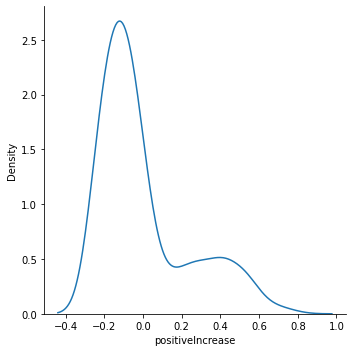

In [ ]:
ndf = data[['date','positiveIncrease']].groupby(by = 'date', as_index = True).sum()
ndf.reset_index(inplace=True, drop=True)

#Normalize dataset for accurate distribution
mean = ndf.positiveIncrease.dropna().mean()
max = ndf.positiveIncrease.dropna().max()
min = ndf.positiveIncrease.dropna().min()
ndf['positiveIncrease'] = ndf['positiveIncrease'].apply(lambda x: (x - mean ) / (max -min ))

sns.displot(ndf, x = 'positiveIncrease', kind = 'kde', height=5, aspect = 1)

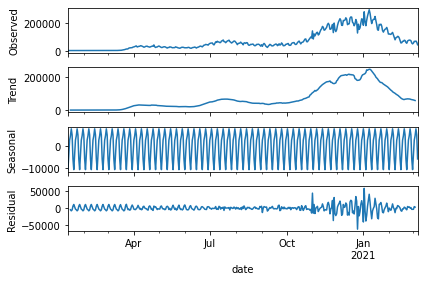

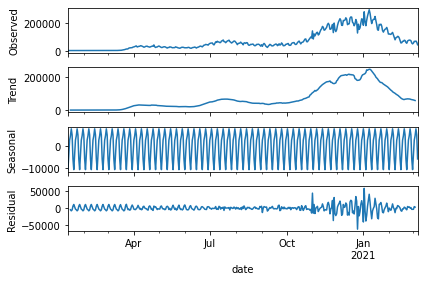

In [ ]:
# Disseminate visually the teh seasonality and noise from the date
data_seasonailty = seasonal_decompose(df)
data_seasonailty.plot()

From the above visualization produced my statsmodels library, we can see that our observed trend consists of two features: Firstly, a certain trend where there is an upward trennd until Jan 2021 followed by a downward trend. Secondly, our trend has a certain seasonaility, followed an residual behaviour, which respresents the noise or the part of the trend that we obtain after removing the seasonality and observed trend.

## **Split the Dataset**

In [ ]:
# Convert the DataFrame into a numpy array using .values method
dataset = df.values

# fix random seed for reproducibility which enables reproducing data randomly enabling random selection of dataset
numpy.random.seed(8)

The Sklearn MixMaxScaler is used to transform the data between given range of 0 and 1. This is known as **feature scaling**, where by we scale the data between desired value range, thus enabling us to remove outlier effect

In [ ]:
# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

We need to split our model into Train and Test data. We set the training data at 70% of entire dataset, while remainder is allocated to test dataset.

In [ ]:
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

294 126


The following helper function helps generate a numpy array, which is the required format for training sequential time-series data in a neural network in Keras. The look back variable is basically the number of time steps that the function needs to trace back, that is used as input values for the following array.

In [ ]:
# Create new function to convert array to dataset matrix for our LSTM Model
# Takes two arguments - dataset in the form of a numpy array and previous time steps to be used as input values

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

## **Neural Network**

Now we need to use our helper function that we have created previously to convert our dataset into numpy arrays while dissecting it into Train and Test sets. Further, we also need to reshape in a 1X3 format, which is the pre-requisite to insert a numpy array into our keras model

In [ ]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print("X_train shape={}, and y_train shape={}".format(trainX.shape, trainY.shape))
print("X_test shape={}, and y_test shape={}".format(testX.shape, testY.shape))

X_train shape=(292, 1, 1), and y_train shape=(292,)
X_test shape=(124, 1, 1), and y_test shape=(124,)


In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=32, verbose=0) 
#To see less information about the model training, set the value of verbose = 0 ('Silent Mode') or verbose = 2 ('Less Information')

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))

> <i><b> NOTE </b> - Run the code blocks under Prediction Section at least 2-3 times, after which you will get the most accruate prediction results, i.e, the prediction line will fit almost perfectly with actual data when plotted.</i>






In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 96        
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


## **Prediction**

In [ ]:
#RMSE values for Training and Test data.
d = {'Training':[trainScore],'Test':[testScore]}
mean_squared_error_1 = pd.DataFrame(data =d, index = ['Score'], dtype = numpy.float32)
mean_squared_error_1

,Training,Test
Score,5031.688965,25548.533203


In [ ]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset) #Creating an empty numpy array
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

## **Visualization**



1.   Visualising with Matplotlib



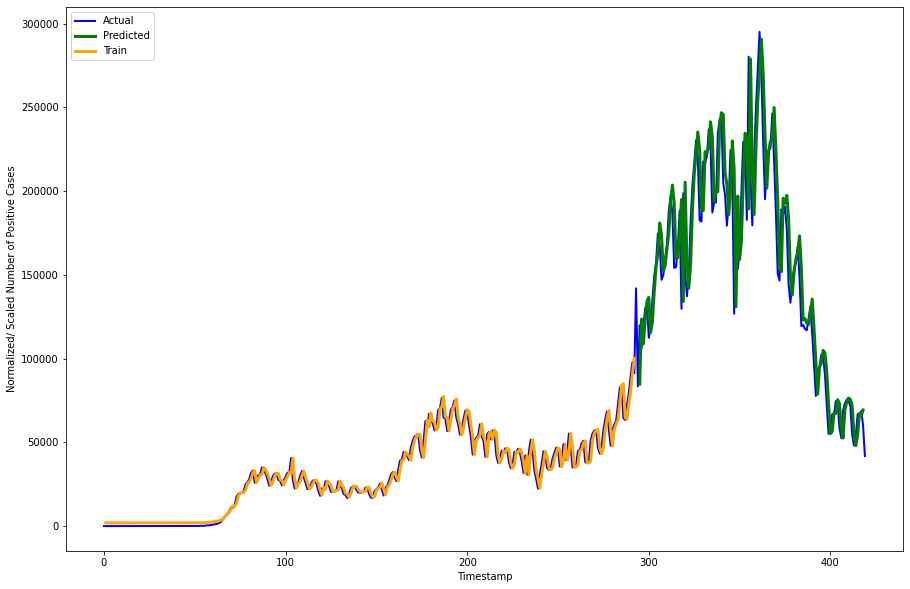

In [ ]:
fig, axs = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(15)

axs.plot(scaler.inverse_transform(dataset),color='blue', label='Actual', linewidth = 2)
axs.plot(testPredictPlot,color='green', label='Predicted', linewidth = 3)
axs.plot(trainPredictPlot,color='orange', label='Train', linewidth = 3)
plt.xlabel('Timestamp')
plt.ylabel('Normalized/ Scaled Number of Positive Cases')
plt.legend(loc='upper left')
plt.show()



2.   Plotting with Plotly



In [ ]:
actual_df = pd.DataFrame(scaler.inverse_transform(dataset))
testPredictPlot_df = pd.DataFrame(testPredictPlot)
trainPredictPlot_df = pd.DataFrame(trainPredictPlot)

fig = go.Figure()

# Overlay line plot for Actual Normalized Data
fig.add_trace(
    go.Scatter(
    x = actual_df.index, #Converting to numpy arrays using .values syntax
    y = actual_df[0],
    mode = 'lines',
    name = 'Actual Data',
    line = dict(color = "#636EFA", width = 5)))

# Superimpose Training Data
fig.add_trace(
    go.Scatter(
    x = trainPredictPlot_df.index.values, 
    y = trainPredictPlot_df[0].values,
    mode = 'lines',
    name = 'Train',
    line=dict(color='#FF7F0E', width = 4)))

# Superimpose Test Data
fig.add_trace(
    go.Scatter(
        x = testPredictPlot_df.index.values,
        y = testPredictPlot_df[0].values,
        mode = "lines",
        name = 'Predicted',
        line = dict(color ='#00CC96', width = 4)
    )
)

fig.update_layout(title = '<b>PREDICTED VS ACTUAL GROWTH OF POSITIVE COVID CASES IN USA</b>',
                  xaxis_title = 'Timestamp',
                  yaxis_title = 'Number of Daily Positive COVID Cases')

In [ ]:
fig2 = px.scatter(df, x = df.index, y = 'positiveIncrease', trendline='ols', 
                  trendline_color_override='orangered',
                  labels={'x':'Date','positiveIncrease': 'Number of Positive Cases'})
fig2.update_layout(title = '<b>COMPARING LINEAR REGRESSION TO OUR LSTM MODEL FOR POSITIVE CASES</b>')

As we can see from the above visualization, where we superimpose training data and prediction based on test data, the neural network model is able to predict the Test Data much better than liner regression. You can hover the plotly model to find the R2_score at each point on the graph

---



# <B><u>FORECASTING RISE IN THE Positive CASES</B>

### **Data Preprocessing**

In this section we first need to determine whether the model that we have trained is able to predict clearly. To determine this, we examine the model by asking it predict a subset of the data, just to clearly see if it able to capture the trend, seasonality and the noise part of the actual data and plot curvature.

In [ ]:
trump = data.query('presidentRule == "Trump"')
trump = trump[['date', 'positiveIncrease']].groupby(by = 'date', as_index = True).sum()
trump = trump.values
trump.shape

(374, 1)

Now we follow the same procedure of transforming the dataset between the values of 0 and 1.

In [ ]:
# Transforming data to fit between 0 and 1, thus removing outlier effects and bias
scaler = MinMaxScaler(feature_range=(0, 1))
trump_data = scaler.fit_transform(trump)
trump_data.shape

(374, 1)

## **Prediction**

After feature scaling, we use our LSTM to do a mock prediction on the trump data that we have sliced from our initial data. Then we need to convert our predicted values which are still between 0 and 1 in terms of actual data, which in this case is in thousands ('000s). Hence, we use sklearns scaler.inverse_transform to transform the feature scaled data back to the inital format.

In [ ]:
#Predict Hospitalizaiton rate under Trump Adminstration based on the previous trainig model
new_output = model.predict(trump_data.reshape(374,1,1)) # Model requires the timesteps in the form of 1 by 3 matrix

#Convert the invereted array into a DataFrame
new_output = scaler.inverse_transform(new_output)
trump_pred = pd.DataFrame(data = new_output, columns = {'Predicted'})

actual_array = scaler.inverse_transform(trump_data)
trump_actual = pd.DataFrame(data = actual_array, columns= {'Actual'}) 

## **Model Fit and Evaluation**

In [ ]:
# Helper function to evaluate the model
def rmse(y_true, y_pred): #Root Mean Squared Error
    mse = mmse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    return 'RMSE = %.3f'%rmse

In [ ]:
def r_squared(y_true, y_pred): # R2_Score
    r2 = r2_score(y_true, y_pred)
    return 'R2_Score = %.3f'%r2

Testing our model to see whether it works on a subset of our actual data. The subset of our data is purely related COVID parameters obtained during Trump Administartion. In this case we observe that our model has trained very well and fits almost perfectly with our actual test data. We achieve an R2_Score of 0.999 most of the time, indicating that our model does a good job of predicting future time steps.

In [ ]:
fig = go.Figure()

fig.add_traces(
    go.Scatter(
        x = trump_pred.index, 
        y = trump_pred['Predicted'].values,
        name = "Predicted",
        mode = 'lines'
        ))
    
fig.add_traces(
    go.Scatter(
        x = trump_actual.index,
        y = trump_actual['Actual'].values,
        name = 'Actual',
        mode = 'lines',
        line = dict(color = '#00CC96')
    )
)

rmse = rmse(trump_actual, trump_pred)
r2 = r_squared(trump_actual, trump_pred)

title = '<b>Predicting Positive COVID cases under Trump Administration </b>'
model_eval = '\n{}, {}'.format(rmse,r2)
plot_title = title, model_eval

fig.update_layout(title = (title + model_eval),
    xaxis_title = 'Timestamp',
    yaxis_title = 'Number of Hospitalized During Trump')

fig.show()

## **Forecasting Future Hospitalization Rates**

In this section we use our training model from the hospitalization training section to <b>forecast</b>, the future values of hospitalizations to get insights of two different things:

1.   How the trend would affect the hospitals and thier ICU ward/ ventilator capacities?
2.   What would have happend if Trump retained the presidency?



In [ ]:
# Manipulating and Transforming the data
trump_2 = data.query('presidentRule == "Trump"')
trump_2 = trump_2[['date', 'positiveIncrease']].groupby(by = 'date', as_index = True).sum()
close_data = trump_2.values
close_data = scaler.fit_transform(close_data)
close_data.shape

(374, 1)

We use the following function to generate future timesteps, whereby we take the last time step that we have in our csv file for the <code>positiveIncrease</code> variable as our input to predict the next output. Further, we use this outpout as an input to determine the next value using our prediction model and so on. We do this for a period of time in number of days as in this code block

In [ ]:
# Function to predict future values through time
# We do this by using the timsteps and data points from the last two datapoints from our hospitalized dataframe
close_data = close_data.reshape((-1))

def predict(num_prediction, model):
    prediction_list = close_data[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = numpy.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
    return prediction_list


# Author - George V Jose
# Website - https:///towardsdatascience.com/time-series-forecasting-with-recurrent-neural-networks-74674e289816
# Date Extracted - 08/11/2021

>The above function is used to predict future values with respect to time. This is done by using the data of the desired number of days starting through the end of original dataset (i.e., hospitalized) and then **forecasting** the hospitalization rates by passing the set number of data through the training model.

In [ ]:
num_prediction = 46
forecast = predict(num_prediction, model)

# Invert the normalized data into its orignal form using inverse_transform
forecast = scaler.inverse_transform(forecast.reshape(forecast.shape[0],1))

# Append the forecasted data to the predicted data for plotting
forecast_array = numpy.append(new_output,forecast)
trump_fcast = pd.DataFrame(data = forecast_array, columns = {'Forecasted'}) 

# Compiling actual array and converting into Dataframe
actual_array_2 = scaler.inverse_transform(close_data.reshape(close_data.shape[0],1))
trump_actual = pd.DataFrame(data = actual_array_2, columns= {'Actual'})

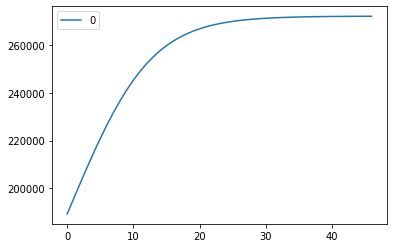

In [ ]:
# Plotting a standalone graph of just forecast for the next 46 time steps.
forecast_df = pd.DataFrame(data = forecast)
forecast_df.plot()

## **Forecast Visualization**

In [ ]:
# Helper function to evaluate the model
def rmse(y_true, y_pred): #Root Mean Squared Error
    mse = mmse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    return 'RMSE = %.3f'%rmse

In [ ]:
def r_squared(y_true, y_pred): # R2_Score
    r2 = r2_score(y_true, y_pred)
    return 'R2_Score = %.3f'%r2

In [ ]:
rmse_forecast = rmse(trump_fcast[0:len(df)], df)
r2_forecast = r2_score(trump_fcast[0:len(df)], df)

In [ ]:
fig = go.Figure()

df_values = pd.DataFrame(data = df.values)

fig.add_traces(
    go.Scatter(
        x = df_values.index,
        y = df_values[0].values,
        mode = 'lines',
        name = 'Actual Positive Cases',
        line = dict(width = 4)
    )
)

fig.add_traces(
    go.Scatter(
        x = trump_fcast.index, 
        y = trump_fcast['Forecasted'].values,
        line = dict(width = 4),
        name = "Forecast Positive Rates",
        mode = 'lines'
        ))



rmse_forecast = rmse(trump_fcast[0:len(df)], df)
r2_forecast = r2_score(trump_fcast[0:len(df)], df)

title = '<b>Forecasted Daily Positive COVID cases under Trump Administration</b>'
model_eval = '{}, R2_Score = {}'.format(rmse_forecast,r2_forecast)

fig.update_layout(title = (title+model_eval), 
                  xaxis_title = 'Timestamp (Days)', 
                  yaxis_title = 'Hospitalization Rate (\'000s)')

fig.show()

# <B><U>INSIGHTS

As we can in our above forecast, that the Red line represents the actual data where as the blue data represents the forecast data. We can clearly observe that had Trump retained his presidency we would have seen an uptick or stagnation of the daily positive cases/ infection rates in contrast to Biden's actual positive cases per day decreased to 41k cases per day. Hence, Trump indeed led to a chaotic proliferation of COVID-19 cases in USA. Our model has achieved a respectiable 0.84, which indicates the level of accuracy in prediction with respect to 1 and given this score, we see that if Trump had remanined president, the daily positie cases would have stagnated to around 145k cases per day at this level r2_score

Furthermore, this model is representative of the magnitude of cases that US would be facing, translating to an urgent need to revamp its capacity to accomodate excess patients in hospitals, thus pointing to the direction for more hospital beds and healthcare expansion if Trump had retained his presidency. Rise of the rise of the delta varaint was a major setbacks in Biden's tenure, but the uptick in cases can also be attributed information asymmetry about vaccination policies and dividied politcs that propelled the general consensys among the public, especially the youth to abandon certain COVID related rules.

# <b><u> RECOMMENDATION

The US should look to imporve the policies such as mandating more stringent rules that will be met with heavier fines or punishments when there is no-compliance. 
More education on COVID to the masses 